## Areial Robot/Car Model  

### Joseph Leung

<p>A nonholonomic WMR without wheel slips— ideal model- Unicycle with radius being one <p>
    
Our states will be controlled by:<p>
$$
\begin{bmatrix}
\dot{q}\\
\end{bmatrix}=
\begin{bmatrix}
\dot{x}\\
\dot{y}\\
\dot{\theta}\\
\end{bmatrix} = 
\begin{bmatrix}
rcos(\theta) & 0\\
rsin(\theta) & 0\\
0 & 1\\
\end{bmatrix}
\begin{bmatrix}
v\\
\omega\\
\end{bmatrix}$$
    
where x is the $V_x$ 
    

In [1]:
clc
close all
clear all

In [19]:
M=[80.8172 2.3194;
    2.3194 .2978];
C=[0 33.8664;
    -.8504 1.6854];
K0=[-80.9500 -2.5995;
    -2.5995 -.8033];
K2=[0 76.5973;
    0 2.6543];
g=9.81;
lambda= pi/10; %pi/2-head nagle %yea this is fixed
%r for rear 
%b for rear frame
%h for front frame
%f for front wheel 
%t for total system
%a for front assembly
vel=5; %how do i figure i stop the velocity 
tra=.08;
wheelb=1.02;
Id=[1 0; 0 1];
zer=zeros(2);
Min=inv(M);
z=[0;0];
oz=[0;1];
A=[-vel*Min*C, -Min.*(g*K0+vel^2*K2) ;
    Id , zer];
    %0, tra*cos(lambda)/wheelb,0, vel*cos(lambda)/wheelb, 0];
%technically I care mostly about the first one THE TOTAL 
B=[Min;zer];
C=[zer,Id];
D=[zer];
M_A = ctrb(A,B);
Rank=rank(M_A); 
[v,d]=eig(A);
Ob=obsv(A,C);
RankO=rank(Ob);


   

In [20]:
%path 
x=-1:.05:1;
y=.4*((1+exp(12*(x))).^-1); %shifted to the right 2 and condensed by 3
y=fliplr(y);
theta(1)=0;
x=50*x;
x=x+50;
y=30*y;
% for f= 2: length(x)
% theta(f)=tan((y(f)-y(f-1))/(x(f)-x(f-1)));
% end

path=[x',y'];
[t, x_des, y_des,dt] = pointToTrajectory(path,0,vel);
for f= 2: length(x_des)
theta(f)=tan((y_des(f)-y_des(f-1))/(x_des(f)-x_des(f-1)));
end


%%%%%%%%%%%%
Q = .01*eye(4);
R = 2^-2*eye(2); %i wanna follow trajectory 
Kvalue = LQR_k(A,B,Q,R);


X_0 = [0;0;0];
X_hat_0 = X_0/2;

Ch = [1 0 0;
    0 1 0];
P_pl = eye(3);
X(:,1)= X_0;
Y(:,1) = Ch*X(:,1);
t(1) = 0;
X_hat(:,1)= X_hat_0;
QQ = .01*eye(2);
tt(1)=0;

In [21]:
for i = 1:length(t)
    u = [vel;theta(i)]; 
%the real thing 
X(:,i+1)= X(:,i) + dt*[u(1)*abs(cos(X(3,i)));
        u(1)*sin(X(3,i));
        u(2)];

    tt(i+1) = tt(i)+dt;
    Y(:,i+1) = Ch*X(:,i+1) + sqrt(R)*randn(size(Ch,1),1); 
    
dFdx = [0 0 -vel*sin(X_hat(3,i)); 0 0 vel*cos(X_hat(3,i)); 0 0 0 ];
    dFdx_d = eye(3) + dt*dFdx;
    
    F = [dt*cos(X_hat(3,i)) 0;
    dt*sin(X_hat(3,i)) 0;
    0 dt];
    
    P_mi = dFdx_d*P_pl*dFdx_d' + F*QQ*F';
       
    X_hat(:,i+1) = X_hat(:,i) + dt*[u(1)*cos(X_hat(3,i));
            u(1)*sin(X_hat(3,i));
          u(2);];
    Y_hat(:,i+1) = Ch*X_hat(:,i+1);
    % Update based on measurement
    e_Y  = Y(:,i+1) - Y_hat(:,i+1);
    S = Ch*P_mi*Ch'+R;
    K = P_mi*Ch'*inv(S);
    P_pl = (eye(3) - K*Ch)*P_mi;
    X_hat(:,i+1)=X_hat(:,i+1) + K*e_Y;
end
X_hat(3,1) = X_hat(3,end);
P_pl = P_mi;

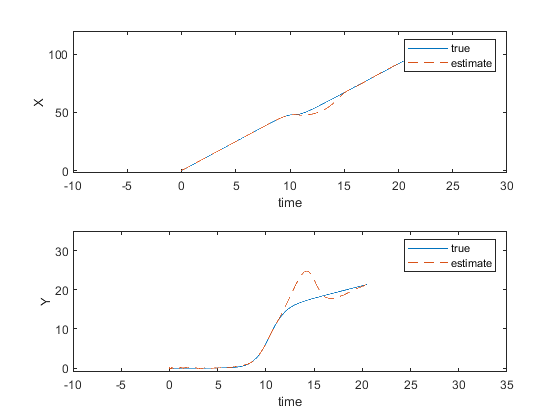

In [22]:
figure;
subplot(2,1,1)
plot(tt,X(1,:),tt,X_hat(1,:),'--')
legend('true','estimate')
%axis([0 2.5 0 40])
xlabel('time')
ylabel('X')
axis([-10 30 -2 120])
subplot(2,1,2)
plot(tt,X(2,:),tt,X_hat(2,:),'--')
legend('true','estimate')
xlabel('time')
ylabel('Y')
axis([-10 35 -1 35])


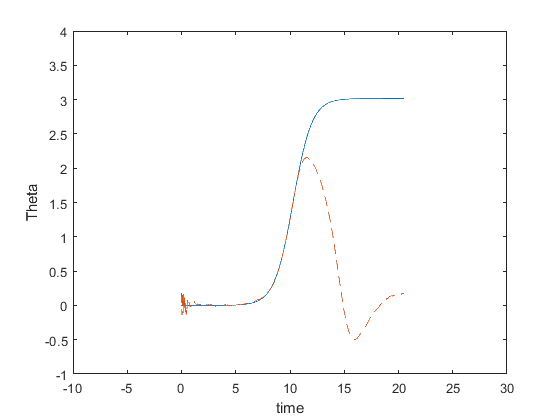

In [23]:
figure;
plot(tt,X(3,:),tt,X_hat(3,:),'--') %X is the actual while X_hat is the measurement based on dynamics
axis([-10 30 -1 4])
xlabel('time')
ylabel('Theta')
%axis([0 2.5 0 2])
